<a href="https://colab.research.google.com/github/Carlosbil/ALL_MY_CNNs/blob/main/Curso_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Convolucionales
Cuso básico

## Introducción Teórica

### ¿Qué es una red neuronal?

### ¿Qué es una CNN?


### ¿Cómo funciona una CNN?

## Cargando nuestro primer dataset

Primer vamos a importar todas las librerías que necesitamos

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [ ]:
# Verifica si CUDA está disponible
cuda_available = torch.cuda.is_available()
print(f"¿CUDA está disponible? {cuda_available}")

# Usamos cuda si se puede, sino la cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

¿CUDA está disponible? True
Usando el dispositivo: cuda


Cargamos el dataset base

In [ ]:
flowers102_raw = datasets.Flowers102(
    root='./data',
    split='train',  # posibles valores 'train', 'val', o 'test'
    download=True
)


Mostramos algunos ejemplos

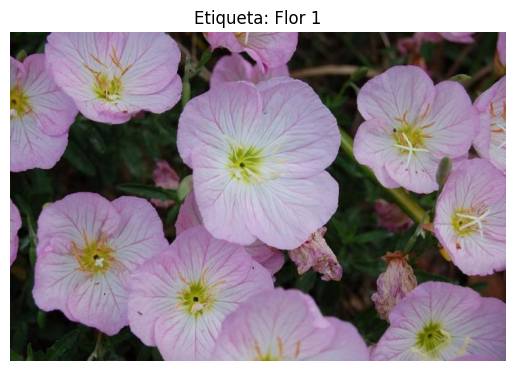

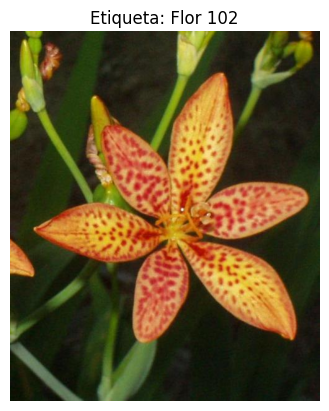

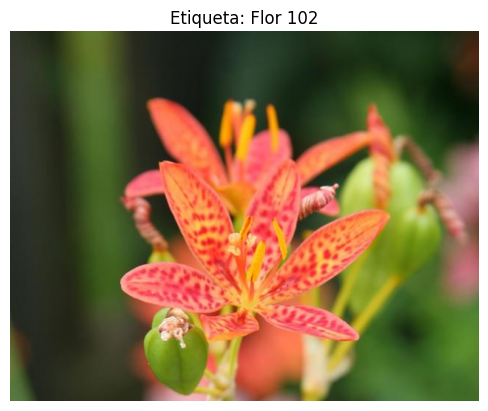

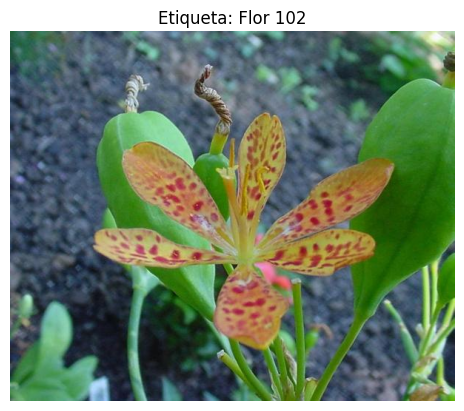

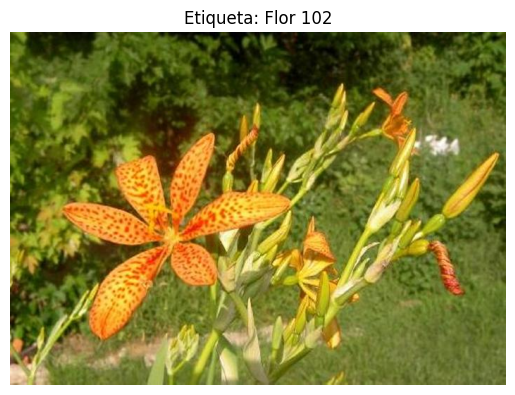

In [ ]:
classes = [f"Flor {i}" for i in range(1, 103)]

# Función para mostrar una imagen
def show_image(img, label):
    plt.imshow(np.array(img))
    plt.title(f"Etiqueta: {classes[label]}")
    plt.axis('off')
    plt.show()

# Mostrar algunas imágenes sin transformaciones
for i in range(5):
    img, label = flowers102_raw[-i]
    show_image(img, label)

### Como podemos aplicar transformaciones

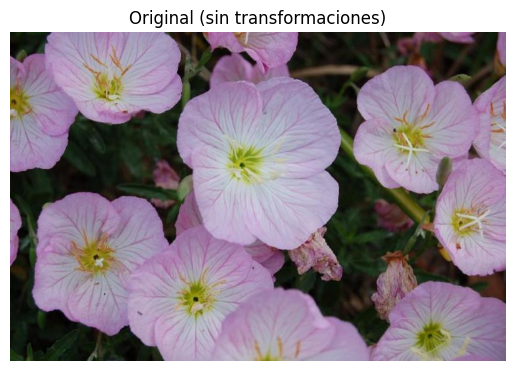

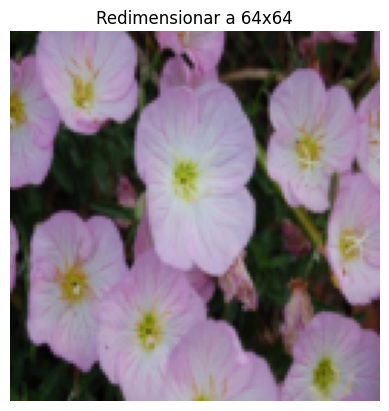

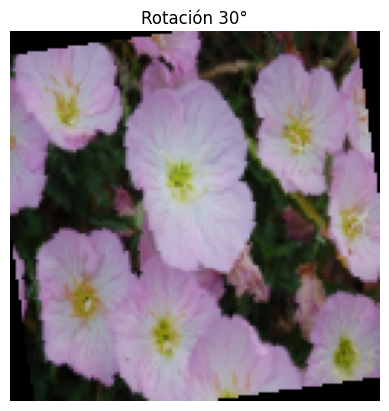

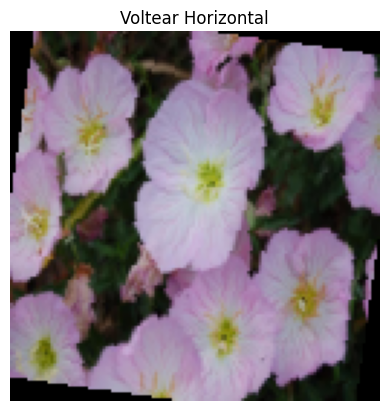

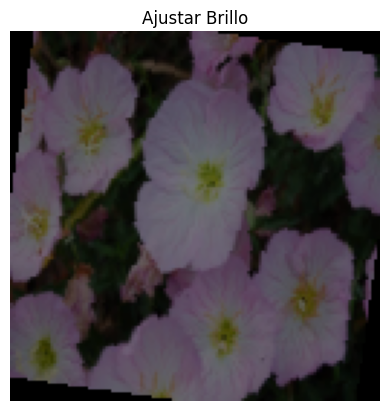

In [ ]:
# Obtener una sola imagen del dataset
img, label = flowers102_raw[0]  # Cambia el índice para seleccionar diferentes imágenes

# Mostrar la imagen original
def show_image(img, title="Original"):
    plt.imshow(np.array(img))
    plt.title(title)
    plt.axis('off')
    plt.show()

show_image(img, "Original (sin transformaciones)")

# Definir transformaciones paso a paso
transform_steps = [
    #("Convertir a Tensor", transforms.ToTensor()),
    ("Redimensionar a 64x64", transforms.Resize((128, 128))), # que pasa si ponemos 64x64 o 32x32?
    ("Rotación 30°", transforms.RandomRotation(30)),
    ("Voltear Horizontal", transforms.RandomHorizontalFlip(p=1.0)),
    ("Ajustar Brillo", transforms.ColorJitter(brightness=0.5)),
    #("Normalización", transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
]

# Aplicar y visualizar cada transformación
transformed_img = img
for step_name, step in transform_steps:
    transform = transforms.Compose([step])
    transformed_img = transform(transformed_img)

    if isinstance(transformed_img, torch.Tensor):  # Convertir tensor para mostrarlo
        np_img = transformed_img.numpy()
        np_img = np.transpose(np_img, (1, 2, 0))  # Cambiar formato de canales
        np_img = np.clip((np_img * 0.5 + 0.5), 0, 1)  # Desnormalizar para visualizar
        plt.imshow(np_img)
    else:  # Imagen en formato PIL
        plt.imshow(np.array(transformed_img))

    plt.title(step_name)
    plt.axis('off')
    plt.show()

### Transformaciones al dataset

Creamos las transformaciones


In [ ]:
# Transformaciones para entrenamiento y validación
# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop((128, 128)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

#Que pasa si probamos con transformaciones más simples para entrenar también?
# Transformaciones para entrenamiento y validación
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Cargamos el dataset con las transformaciones deseadas

In [ ]:
# Cargar dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Construyendo Nuestra primera CNN


In [ ]:
class FlowersNet(nn.Module):
    def __init__(self):
        super(FlowersNet, self).__init__()
        self.conv_layers = nn.Sequential(
            # (3, 64, kernel_size=3, stride=1, padding=1),
            # (in_channel, out channels, kernel_size, stride, padding)
            # en este caso es 3 porque la entrada es a color RGB, si usarmaos en blanco y negro sería uno

            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 102)  # 102 clases para Flowers 102
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## Entrenando y evaluando el modelo

Inicializamos el modelo

In [ ]:
model = FlowersNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Barra de progreso para entrenamiento
        train_progress = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_progress.set_postfix(loss=loss.item())

        train_acc = 100 * correct / total
        print(f"Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%")

        # Evaluar en el conjunto de validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_progress = tqdm(val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.2f}%")


# Entrenar el modelo
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Guardar el modelo
torch.save(model.state_dict(), 'flowers102_cnn.pth')

Epoch 1/10


Train Loss: 4.6870, Train Accuracy: 0.59%


Validation Loss: 4.5884, Validation Accuracy: 2.35%
Epoch 2/10


Train Loss: 4.4302, Train Accuracy: 2.06%


Validation Loss: 4.1931, Validation Accuracy: 4.22%
Epoch 3/10


Train Loss: 4.0752, Train Accuracy: 4.71%


Validation Loss: 4.0650, Validation Accuracy: 5.78%
Epoch 4/10


Train Loss: 3.8201, Train Accuracy: 9.71%


Validation Loss: 3.8918, Validation Accuracy: 7.84%
Epoch 5/10


Train Loss: 3.4590, Train Accuracy: 14.51%


Validation Loss: 3.8207, Validation Accuracy: 8.82%
Epoch 6/10


Train Loss: 3.0421, Train Accuracy: 25.69%


Validation Loss: 3.8873, Validation Accuracy: 12.84%
Epoch 7/10


Train Loss: 2.4222, Train Accuracy: 38.14%


Validation Loss: 4.0017, Validation Accuracy: 12.84%
Epoch 8/10


Train Loss: 1.7084, Train Accuracy: 54.51%


Validation Loss: 4.1618, Validation Accuracy: 12.75%
Epoch 9/10


Train Loss: 1.0614, Train Accuracy: 71.18%


Validation Loss: 4.8799, Validation Accuracy: 11.27%
Epoch 10/10


Train Loss: 0.6970, Train Accuracy: 79.90%


Validation Loss: 4.8703, Validation Accuracy: 13.04%


Que está pasando?

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
STEP_SIZE = 7     # cada cuántas épocas reduce el LR
GAMMA = 0.1       # factor de reducción del LR en cada step del scheduler
NUM_CLASSES = 102 # Oxford Flowers 102
INPUT_SIZE = 224  # Redimensionaremos las imágenes a 224x224


class FlowersNet2(nn.Module):
    """
    CNN profunda con 4 bloques:
    - Conv2D -> BatchNorm -> ReLU -> MaxPool
    - Repetir 4 veces, aumentando canales.

    Luego 2 capas densas con Dropout.
    """
    def __init__(self, num_classes=NUM_CLASSES):
        super(FlowersNet2, self).__init__()

        # Bloque 1: 3 -> 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bloque 2: 64 -> 128
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bloque 3: 128 -> 256
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        # Después de 4 veces pooling (factor 2 cada vez):
        # Tamaño final = INPUT_SIZE / (2^4) = 224 / 16 = 14, si la entrada es 224x224
        # 512 canales
        # Flatten -> FC
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 1024),  # 512*8*8=32768
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc_layers(x)
        return x

model = FlowersNet2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

# Guardar el modelo
torch.save(model.state_dict(), 'flowers102_cnn.pth')

Epoch 1/100


Train Loss: 5.1133, Train Accuracy: 0.98%


Validation Loss: 4.5509, Validation Accuracy: 2.75%
Epoch 2/100


Train Loss: 4.6235, Train Accuracy: 2.16%


Validation Loss: 4.4594, Validation Accuracy: 5.78%
Epoch 3/100


Train Loss: 4.4930, Train Accuracy: 2.84%


Validation Loss: 4.3491, Validation Accuracy: 6.67%
Epoch 4/100


Train Loss: 4.4475, Train Accuracy: 3.04%


Validation Loss: 4.2707, Validation Accuracy: 6.57%
Epoch 5/100


Train Loss: 4.3198, Train Accuracy: 4.31%


Validation Loss: 4.1409, Validation Accuracy: 8.53%
Epoch 6/100


Train Loss: 4.2413, Train Accuracy: 5.88%


Validation Loss: 4.0488, Validation Accuracy: 12.55%
Epoch 7/100


Train Loss: 4.0870, Train Accuracy: 8.04%


Validation Loss: 3.9702, Validation Accuracy: 14.61%
Epoch 8/100


Train Loss: 4.0118, Train Accuracy: 8.82%


Validation Loss: 3.8455, Validation Accuracy: 14.71%
Epoch 9/100


Train Loss: 3.9156, Train Accuracy: 8.24%


Validation Loss: 3.7733, Validation Accuracy: 14.90%
Epoch 10/100


Train Loss: 3.8086, Train Accuracy: 12.35%


Validation Loss: 3.6585, Validation Accuracy: 16.86%
Epoch 11/100


Train Loss: 3.6706, Train Accuracy: 12.25%


Validation Loss: 3.6144, Validation Accuracy: 19.41%
Epoch 12/100


Train Loss: 3.5559, Train Accuracy: 14.61%


Validation Loss: 3.5047, Validation Accuracy: 21.57%
Epoch 13/100


Train Loss: 3.4775, Train Accuracy: 16.96%


Validation Loss: 3.4708, Validation Accuracy: 19.80%
Epoch 14/100


Train Loss: 3.2811, Train Accuracy: 18.43%


Validation Loss: 3.3863, Validation Accuracy: 23.43%
Epoch 15/100


Train Loss: 3.1423, Train Accuracy: 21.37%


Validation Loss: 3.2984, Validation Accuracy: 23.53%
Epoch 16/100


Train Loss: 3.0581, Train Accuracy: 24.41%


Validation Loss: 3.2471, Validation Accuracy: 24.41%
Epoch 17/100


Train Loss: 2.9730, Train Accuracy: 25.29%


Validation Loss: 3.2284, Validation Accuracy: 25.29%
Epoch 18/100


Train Loss: 2.7634, Train Accuracy: 29.41%


Validation Loss: 3.1393, Validation Accuracy: 26.96%
Epoch 19/100


Train Loss: 2.6782, Train Accuracy: 31.37%


Validation Loss: 3.0896, Validation Accuracy: 25.78%
Epoch 20/100


Train Loss: 2.5296, Train Accuracy: 33.04%


Validation Loss: 3.0336, Validation Accuracy: 27.75%
Epoch 21/100


Train Loss: 2.4190, Train Accuracy: 37.25%


Validation Loss: 2.9852, Validation Accuracy: 28.43%
Epoch 22/100


Train Loss: 2.3353, Train Accuracy: 37.45%


Validation Loss: 2.9753, Validation Accuracy: 28.33%
Epoch 23/100


Train Loss: 2.2320, Train Accuracy: 41.08%


Validation Loss: 2.9101, Validation Accuracy: 29.80%
Epoch 24/100


Train Loss: 2.0379, Train Accuracy: 45.00%


Validation Loss: 2.9134, Validation Accuracy: 28.63%
Epoch 25/100


Train Loss: 2.0219, Train Accuracy: 45.39%


Validation Loss: 2.9123, Validation Accuracy: 30.10%
Epoch 26/100


Train Loss: 1.8530, Train Accuracy: 51.18%


Validation Loss: 2.8594, Validation Accuracy: 31.67%
Epoch 27/100


Train Loss: 1.7591, Train Accuracy: 52.94%


Validation Loss: 2.8183, Validation Accuracy: 31.27%
Epoch 28/100


Train Loss: 1.5809, Train Accuracy: 55.00%


Validation Loss: 2.8314, Validation Accuracy: 31.67%
Epoch 29/100


Train Loss: 1.5299, Train Accuracy: 58.73%


Validation Loss: 2.8164, Validation Accuracy: 31.67%
Epoch 30/100


Train Loss: 1.4410, Train Accuracy: 59.02%


Validation Loss: 2.7862, Validation Accuracy: 31.86%
Epoch 31/100


Train Loss: 1.3138, Train Accuracy: 63.04%


Validation Loss: 2.7863, Validation Accuracy: 32.94%
Epoch 32/100


Train Loss: 1.2956, Train Accuracy: 62.84%


Validation Loss: 2.8137, Validation Accuracy: 31.96%
Epoch 33/100


Train Loss: 1.2055, Train Accuracy: 67.06%


Validation Loss: 2.8574, Validation Accuracy: 29.71%
Epoch 34/100


Train Loss: 1.1568, Train Accuracy: 66.76%


Validation Loss: 2.7808, Validation Accuracy: 33.14%
Epoch 35/100


Train Loss: 1.0445, Train Accuracy: 71.18%


Validation Loss: 2.7574, Validation Accuracy: 32.45%
Epoch 36/100


Train Loss: 1.0220, Train Accuracy: 70.88%


Validation Loss: 2.7847, Validation Accuracy: 32.45%
Epoch 37/100


Train Loss: 0.9667, Train Accuracy: 73.14%


Validation Loss: 2.7309, Validation Accuracy: 33.73%
Epoch 38/100


Train Loss: 0.8473, Train Accuracy: 76.37%


Validation Loss: 2.7878, Validation Accuracy: 32.25%
Epoch 39/100


Train Loss: 0.8108, Train Accuracy: 77.94%


Validation Loss: 2.7558, Validation Accuracy: 33.43%
Epoch 40/100


Train Loss: 0.7838, Train Accuracy: 78.73%


Validation Loss: 2.7630, Validation Accuracy: 33.73%
Epoch 41/100


Train Loss: 0.7593, Train Accuracy: 78.53%


Validation Loss: 2.7686, Validation Accuracy: 33.63%
Epoch 42/100


Train Loss: 0.6626, Train Accuracy: 81.76%


Validation Loss: 2.7734, Validation Accuracy: 32.06%
Epoch 43/100


Train Loss: 0.6822, Train Accuracy: 81.57%


Validation Loss: 2.7891, Validation Accuracy: 31.57%
Epoch 44/100


Train Loss: 0.6323, Train Accuracy: 82.55%


Validation Loss: 2.7836, Validation Accuracy: 33.24%
Epoch 45/100


Train Loss: 0.6185, Train Accuracy: 83.33%


Validation Loss: 2.7930, Validation Accuracy: 33.82%
Epoch 46/100


Train Loss: 0.6345, Train Accuracy: 81.37%


Validation Loss: 2.8368, Validation Accuracy: 32.65%
Epoch 47/100


Train Loss: 0.5550, Train Accuracy: 84.22%


Validation Loss: 2.8798, Validation Accuracy: 33.43%
Epoch 48/100


Train Loss: 0.5048, Train Accuracy: 85.69%


Validation Loss: 2.8368, Validation Accuracy: 32.94%
Epoch 49/100


Train Loss: 0.5512, Train Accuracy: 85.29%


Validation Loss: 2.7947, Validation Accuracy: 33.53%
Epoch 50/100


Train Loss: 0.5245, Train Accuracy: 84.22%


Validation Loss: 2.8954, Validation Accuracy: 32.16%
Epoch 51/100


Train Loss: 0.5332, Train Accuracy: 84.41%


Validation Loss: 2.8710, Validation Accuracy: 31.67%
Epoch 52/100


Train Loss: 0.4755, Train Accuracy: 86.57%


Validation Loss: 2.8549, Validation Accuracy: 32.94%
Epoch 53/100


Train Loss: 0.4442, Train Accuracy: 87.45%


Validation Loss: 2.8851, Validation Accuracy: 32.35%
Epoch 54/100


Train Loss: 0.3865, Train Accuracy: 88.33%


Validation Loss: 2.8802, Validation Accuracy: 32.45%
Epoch 55/100


Train Loss: 0.4232, Train Accuracy: 88.53%


Validation Loss: 2.8849, Validation Accuracy: 32.84%
Epoch 56/100


Train Loss: 0.3699, Train Accuracy: 89.12%


Validation Loss: 2.9057, Validation Accuracy: 34.31%
Epoch 57/100


Train Loss: 0.3458, Train Accuracy: 90.29%


Validation Loss: 2.8942, Validation Accuracy: 33.92%
Epoch 58/100


Train Loss: 0.3651, Train Accuracy: 89.31%


Validation Loss: 2.8661, Validation Accuracy: 31.67%
Epoch 59/100


Train Loss: 0.3332, Train Accuracy: 91.18%


Validation Loss: 3.0071, Validation Accuracy: 32.94%
Epoch 60/100


Train Loss: 0.3946, Train Accuracy: 87.45%


Validation Loss: 2.9529, Validation Accuracy: 33.14%
Epoch 61/100


Train Loss: 0.3511, Train Accuracy: 90.20%


Validation Loss: 3.0168, Validation Accuracy: 33.53%
Epoch 62/100


Train Loss: 0.3241, Train Accuracy: 90.98%


Validation Loss: 2.9705, Validation Accuracy: 33.14%
Epoch 63/100


Train Loss: 0.3307, Train Accuracy: 90.69%


Validation Loss: 2.9857, Validation Accuracy: 32.45%
Epoch 64/100


Train Loss: 0.2904, Train Accuracy: 91.86%


Validation Loss: 3.0278, Validation Accuracy: 34.02%
Epoch 65/100


Train Loss: 0.3175, Train Accuracy: 91.08%


Validation Loss: 2.8627, Validation Accuracy: 33.14%
Epoch 66/100


Train Loss: 0.2827, Train Accuracy: 91.67%


Validation Loss: 2.9965, Validation Accuracy: 32.65%
Epoch 67/100


Train Loss: 0.2745, Train Accuracy: 93.04%


Validation Loss: 2.9576, Validation Accuracy: 34.41%
Epoch 68/100


Train Loss: 0.3214, Train Accuracy: 91.76%


Validation Loss: 2.9536, Validation Accuracy: 33.43%
Epoch 69/100


Train Loss: 0.2365, Train Accuracy: 93.82%


Validation Loss: 3.0212, Validation Accuracy: 34.71%
Epoch 70/100


Train Loss: 0.2247, Train Accuracy: 93.04%


Validation Loss: 3.0440, Validation Accuracy: 34.22%
Epoch 71/100


Train Loss: 0.2583, Train Accuracy: 91.96%


Validation Loss: 3.0895, Validation Accuracy: 33.53%
Epoch 72/100


Train Loss: 0.2598, Train Accuracy: 92.65%


Validation Loss: 3.0491, Validation Accuracy: 33.82%
Epoch 73/100


Train Loss: 0.2395, Train Accuracy: 93.43%


Validation Loss: 3.0083, Validation Accuracy: 33.14%
Epoch 74/100


Train Loss: 0.2377, Train Accuracy: 92.75%


Validation Loss: 3.0685, Validation Accuracy: 33.33%
Epoch 75/100


Train Loss: 0.2006, Train Accuracy: 94.61%


Validation Loss: 3.1507, Validation Accuracy: 32.75%
Epoch 76/100


Train Loss: 0.2159, Train Accuracy: 93.53%


Validation Loss: 3.0923, Validation Accuracy: 32.35%
Epoch 77/100


Train Loss: 0.2075, Train Accuracy: 94.41%


Validation Loss: 3.1318, Validation Accuracy: 33.24%
Epoch 78/100


Train Loss: 0.2333, Train Accuracy: 93.33%


Validation Loss: 3.0433, Validation Accuracy: 34.71%
Epoch 79/100


Train Loss: 0.1891, Train Accuracy: 94.12%


Validation Loss: 3.1699, Validation Accuracy: 32.84%
Epoch 80/100


Train Loss: 0.1797, Train Accuracy: 94.80%


Validation Loss: 3.0346, Validation Accuracy: 33.24%
Epoch 81/100


Train Loss: 0.1799, Train Accuracy: 95.00%


Validation Loss: 3.1337, Validation Accuracy: 33.92%
Epoch 82/100


Train Loss: 0.1898, Train Accuracy: 95.20%


Validation Loss: 3.0856, Validation Accuracy: 33.04%
Epoch 83/100


Train Loss: 0.1706, Train Accuracy: 95.20%


Validation Loss: 3.1474, Validation Accuracy: 34.41%
Epoch 84/100


Train Loss: 0.1639, Train Accuracy: 95.59%


Validation Loss: 3.0710, Validation Accuracy: 34.41%
Epoch 85/100


Train Loss: 0.2266, Train Accuracy: 92.75%


Validation Loss: 3.1176, Validation Accuracy: 33.43%
Epoch 86/100


Train Loss: 0.1913, Train Accuracy: 94.90%


Validation Loss: 3.1056, Validation Accuracy: 33.33%
Epoch 87/100


Train Loss: 0.1939, Train Accuracy: 94.31%


Validation Loss: 3.1256, Validation Accuracy: 34.61%
Epoch 88/100


Train Loss: 0.2017, Train Accuracy: 93.92%


Validation Loss: 3.1674, Validation Accuracy: 32.84%
Epoch 89/100


Train Loss: 0.2217, Train Accuracy: 93.92%


Validation Loss: 3.1705, Validation Accuracy: 31.57%
Epoch 90/100


Train Loss: 0.1695, Train Accuracy: 95.29%


Validation Loss: 3.2805, Validation Accuracy: 33.24%
Epoch 91/100


Train Loss: 0.1874, Train Accuracy: 94.71%


Validation Loss: 3.2293, Validation Accuracy: 32.35%
Epoch 92/100


Train Loss: 0.1881, Train Accuracy: 94.12%


Validation Loss: 3.3629, Validation Accuracy: 32.55%
Epoch 93/100


Train Loss: 0.1715, Train Accuracy: 94.90%


Validation Loss: 3.2328, Validation Accuracy: 33.53%
Epoch 94/100


Train Loss: 0.1982, Train Accuracy: 94.41%


Validation Loss: 3.1585, Validation Accuracy: 34.31%
Epoch 95/100


Train Loss: 0.1749, Train Accuracy: 94.41%


Validation Loss: 3.3259, Validation Accuracy: 32.55%
Epoch 96/100


Train Loss: 0.1894, Train Accuracy: 94.41%


Validation Loss: 3.2273, Validation Accuracy: 32.25%
Epoch 97/100


Train Loss: 0.1908, Train Accuracy: 94.22%


Validation Loss: 3.1944, Validation Accuracy: 34.02%
Epoch 98/100


Train Loss: 0.1637, Train Accuracy: 95.10%


Validation Loss: 3.2411, Validation Accuracy: 31.67%
Epoch 99/100


Train Loss: 0.1679, Train Accuracy: 95.10%


Validation Loss: 3.1613, Validation Accuracy: 34.31%
Epoch 100/100


Train Loss: 0.1524, Train Accuracy: 95.49%


Validation Loss: 3.1484, Validation Accuracy: 34.41%


## Mejorando la red...

## Prueba Final